<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/master/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6: Differential Equations**
**Hilaire Bouaddi**

# **Abstract**

The objectives of the lab are to implement time stepping methods for initial value problems. We will then plot results in terms of accuracy and stability. The time stepping method used here is the trapezoidal method. It is supposed to be inconditionally stable and this is what we have observed in this lab.

# **Set up environment**

In [27]:
import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation, rc
from IPython.display import HTML

# **Introduction**

For the first part, we will try to solve a scalar initial value problem with the form $\frac{du}{dt} = f(u, t)$.
We will try to solve the problem using the $\theta$-method with $\theta = 0.5$. This method is equivalent with the trapezoidal method and takes the form: 

$U_n = U_{n-1} + \theta \Delta tf(U_{n-1}, t_{n-1}) + (1-\theta)\Delta tf(U_n, t_n)$

This method is unconditionally stable so the solution should not diverge. We will use the fixed point iteration method to estimate $U_n$

For the 2nd part, we will solve a system of initial value problems. We will also use the trapezoidal method than can be rewritten as: 

$U_n = U_{n-1} + \frac{\Delta t}2 (F(U_{n-1}, t_{n-1} + F(U_n, t_n))$ where $F(U_n) = 
\begin{pmatrix}
    \dot u_1(t_n) \\ 
    \dot u_2(t_n) \\ 
    \vdots \\ 
    \dot u_k(t_n)
\end{pmatrix}$ where $k$ is the dimension of U.

Since the first part is just the case where the dimension of U is 1, we will try to implement one single function for the trapezoidal method.

We will also try to model the wave equation from the course with the function that we implemented for the previous parts. 

# **Method**

## Time stepping for scalar initial value problem and system initial value problem

In [14]:
# Input: final time T, function f(u,t), initial value u(0)
# Output: approximation U(t_n) for the time interval [0,T] 

def fixed_point_iteration(f, u_nm1, t_n, dt, epochs=1000):
    # maybe having a TOL parameter would be more reasonable
    new_u = u_nm1
    for _ in range(epochs):
        new_u = u_nm1 + dt*f(new_u, t_n)
        
    return new_u

# N will be the number of steps
def initial_value_problem(T, f, u_0, theta=0.5, N=50):
    dt = T/N
    us = [u_0]
    
    for i in range(1, N + 1):
        t_nm1 = dt * (i - 1)
        t_n = dt * i
        
        # 0.5dt * f(U_n-1, t_n-1)
        explicit_component = dt * f(us[i-1], t_nm1)
        
        # u_t for the implicit part 
        u_t = fixed_point_iteration(f, us[i-1], t_n, dt)
        
        implicit_component = dt * f(u_t, t_n)
        
        us.append(us[i-1] + theta*explicit_component + (1-theta)*implicit_component)
        
    return np.array(us)




## Extra: Computational experiment - Wave propagation

For this extra assignment, we will try to implement the model of a wave.

We will have a system of mass $M$ composed of $N$ particles that we will model for time $T$ seconds. The mass of each particle is called $m$. The particles form a chain of length L and are distant from one another by $h = L/N$. Finally each particle is connected to its "left" and "right" neighbors. Let's try to model this system using the lecture's result: 

$\ddot x - c^2x'' = 0$ where c is a propagation speed constant that we will choose.

In [15]:
# CONSTANTS 

N = 20 # number of particles
T = 10 # seconds

M = 1 # mass of system
m = M/N # mass of a particle

k = 0.5 # stiffness of the spring 

L = 1 # length of system
h = L/N # particle separated by h

c = 1 # propagation speed

We will now define function f such that $\dot u(t) = f(u(t), t)$

For this, we will have $u = \begin{pmatrix}x_1\\\vdots\\x_N\\v_1\\\vdots\\v_N\end{pmatrix}$ and, by Newton 2nd law, $f = \begin{pmatrix}v_1\\\vdots\\v_N\\F_1/m\\\vdots\\F_N/m\end{pmatrix}$

In [16]:
equilibrium_xs = np.linspace(0, L, N) # the positions at equilibrium

u = np.zeros((2*N))
u[:N] = equilibrium_xs

def show_system_state(u):
    return plt.scatter(u[:N], np.zeros(N))

In [17]:
class function_wave:
    def __call__(self, u, t):
        result = np.zeros(2*N)
        result[:N] = u[N:]
        
        # compute force 
        F = np.zeros(N)
        xs = u[:N] - equilibrium_xs
        for i in range(1, N-1): # the particles on the edges dissipate 100% of the energy and will never move
            F[i] = k*(xs[i+1] - 2*xs[i] + xs[i-1])
        
        result[N:] = F/m
        
        return result
    
f = function_wave()

In [18]:
# we will give a small perturbation to the second particle 
u[1] = (u[2] + u[1])/2

modelisation = initial_value_problem(T, f, u, theta=0.5, N=100) 

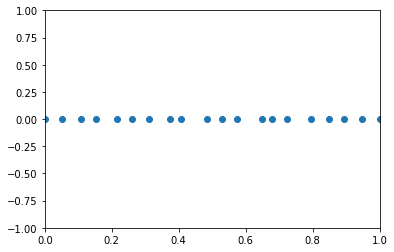

In [19]:
%matplotlib inline

fig, ax = plt.subplots()
ax.axis([0,1,-1,1])
l = ax.scatter([],[])

def animate(i):
    l.set_offsets(np.stack((modelisation[i, :N], np.zeros(N)), axis=1))

ani = animation.FuncAnimation(fig, animate, frames=100)

from IPython.display import HTML
HTML(ani.to_jshtml())

# **Results**

## Testing Time stepping for scalar initial value problem

We will first try to approximate $e^{-t}$.

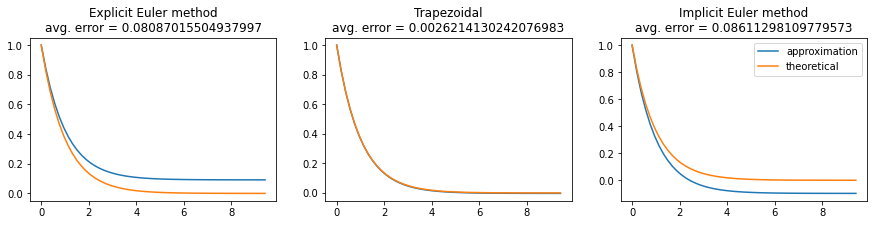

In [8]:
class function:
    def __call__(self, u_t, t):
        return -np.exp(-t) 
    
    def theoretical_answer(self, t):
        return np.exp(-t)

f = function()

T = 3*np.pi
N = 50
results05 = initial_value_problem(T, f, 1, theta=0.5, N=N)
results00 = initial_value_problem(T, f, 1, theta=0, N=N)
results10 = initial_value_problem(T, f, 1, theta=1, N=N)

ts = np.linspace(0, T, len(results00))

plt.figure(figsize=(15,3))

plt.subplot(131)
plt.plot(ts, results00, label="approximation")
plt.plot(ts, f.theoretical_answer(ts), label="theoretical")
plt.title(f"Explicit Euler method\navg. error = {np.mean(np.abs(f.theoretical_answer(ts) - results00))}")

plt.subplot(132)
plt.plot(ts, results05, label="approximation")
plt.plot(ts, f.theoretical_answer(ts), label="theoretical")
plt.title(f"Trapezoidal\navg. error = {np.mean(np.abs(f.theoretical_answer(ts) - results05))}")

plt.subplot(133)
plt.plot(ts, results10, label="approximation")
plt.plot(ts, f.theoretical_answer(ts), label="theoretical")
plt.title(f"Implicit Euler method\navg. error = {np.mean(np.abs(f.theoretical_answer(ts) - results10))}")

plt.legend()

As we can see the trapezoidal method gives the best results for the accuracy. We can also say that only the trapezoidal method is stable since it is the only one that converges to 0. We can also try to slightly change the initial condition.

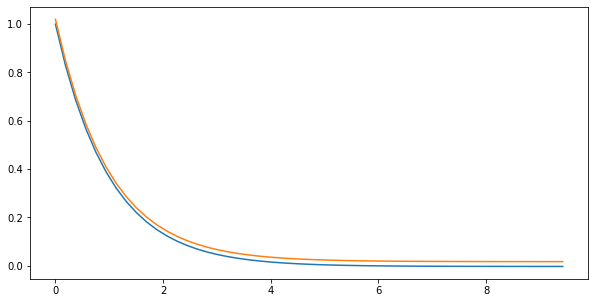

In [26]:
f = function()

T = 3*np.pi
N = 50

ts = np.linspace(0, T, len(results00))

plt.figure(figsize=(10, 5))

theta = 0.5
results = initial_value_problem(T, f, 1, theta=theta)
results_perturbed = initial_value_problem(T, f, 1.02, theta=theta)

plt.plot(ts, results, label="approximation")
plt.plot(ts, results_perturbed, label="perturbed")

The error is constant and doesn't accumulate.

## Testing Time stepping for system initial value problem

We will use the system of exercise 14.1.

$
\begin{equation}
    \dot u_1(t) = u_2(t), \\ 
    \dot u_2(t) = -u_1(t)
\end{equation}
$

We know that with initial conditions $u_1(t) = 0$ and $u_2(0) = 1$, the theoretical solution is $(sin(t), cos(t))$

Text(0, 0.5, 'u_2(t)')

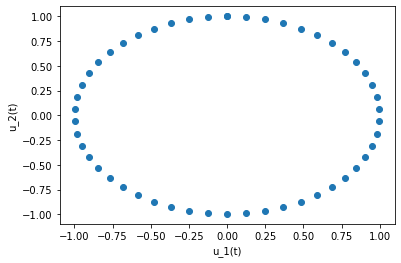

In [10]:
class Function14_1:
    
    def __call__(self, U, t):
        return np.array([np.cos(t), -np.sin(t)])
    
    def theoretical_solution(self, U, t):
        return np.array([np.sin(t), np.cos(t)])
    
f = Function14_1()
T = 2*np.pi
res = initial_value_problem(T, f, [0, 1])

plt.scatter(res[:, 0], res[:, 1])
plt.xlabel("u_1(t)")
plt.ylabel("u_2(t)")

We chose to plot $u_2(t)$ depending on $u_1(t)$. We get a circle as expected since the equations form parametric equations for the trigonometric circle. 

# **Discussion**

It seems that the trapezoidal method is an overall better method than explicit or implicit Euler method both in accuracy and stability. It was very rewarding to be able to model the wave equation. However, it may be a bad choice to fix the 2 edges of the chain since the system will start dissipating energy. Also, we can wonder if it would be a good idea to have "exponential" springs. The linear springs are not very well suited for very stiff springs and the particles could interpenetrate. 